# Using the NN model to calculate monthly estimate

Below are code to uses ESA Scope project WP2 DOC model to estimate monthly DOC for given input data.
The model is a neural network model using Tensorflow package. File `requirements.txt` lists the package requiements.

In [1]:
import pickle
import numpy as np
import xarray as xr
import tensorflow as tf

import matplotlib.pyplot as plt

import scope_config as config
from scope_config import Rrs, units

2024-12-18 14:28:56.322887: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 14:28:56.451589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 14:28:56.451736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 14:28:56.473772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 14:28:56.521705: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 14:28:56.522590: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
tf.__version__

'2.15.0'


### Input data

| variable | name | units | link |
|:--|:--|:--|:--|
|OC-CCI v6 | Rrs_nnn | sr⁻¹ | https://dx.doi.org/10.5285/5011d22aae5a4671b0cbc7d05c56c4f0 |
|PP    | pp | mgC m⁻² d⁻¹ | https://rsg.pml.ac.uk/shared_files/gku/SCOPE/PP_v6_9km/ |
|SST   | temp | °C | https://dx.doi.org/10.5285/4a9654136a7148e39b7feb56f8bb02d2 |
|SSS   | salt | PSS-78 | https://doi.org/10.48670/moi-00021 |
|dts   | dts |  km | distance to shore |
|depth | depth | m | water depth from bathymetry |

File `DOC_model_input_2020_06.nc` has an example of input data for one month. It has smaller spatial resolution than the final product.


In [3]:
ds = xr.open_dataset('DOC_model_input_2020_06.nc')
ds

<xarray.Dataset> Size: 30MB
Dimensions:  (lat: 540, lon: 1080)
Coordinates:
  * lat      (lat) float32 2kB -89.83 -89.5 -89.17 -88.83 ... 89.17 89.5 89.83
  * lon      (lon) float32 4kB -179.8 -179.5 -179.2 -178.8 ... 179.2 179.5 179.8
    time     datetime64[ns] 8B ...
    depth    (lat, lon) float32 2MB ...
Data variables:
    salt     (lat, lon) float64 5MB ...
    pp       (lat, lon) float64 5MB ...
    Rrs_412  (lat, lon) float32 2MB ...
    Rrs_443  (lat, lon) float32 2MB ...
    Rrs_490  (lat, lon) float32 2MB ...
    Rrs_510  (lat, lon) float32 2MB ...
    Rrs_560  (lat, lon) float32 2MB ...
    Rrs_665  (lat, lon) float32 2MB ...
    temp     (lat, lon) float32 2MB ...
    dts      (lat, lon) float32 2MB ...
Attributes:
    title:    Demo file for the SCOPE project

### Model

The model definitions are stored in two files.

| file | what |
|:--|:--|
|`nn_model_data_esa-scope_v1.4.pkl`| training data, variables names, and scaler |
|`nn_model_esa-scope_v1.4.keras`| Tensorflow model |

Tensorflow version 2.15 was used for training and is needed to use the model.

In [4]:
modeldir = 'models'
model_version = 'v1.5'
label0 = 'esa-scope'
datafile = f'{modeldir}/nn_model_data_{label0}_{model_version}.pkl'
modelfile = f'{modeldir}/nn_model_{label0}_{model_version}.keras'

data = pickle.load(open(datafile, 'rb'))
names = data['names']
scaler = data['scaler']
model = tf.keras.models.load_model(modelfile)

### Estimation

The function `estimate_DOC` defined below uses xarray Dataset as input. The function `model.predict` is used to calculate model predictions for every valid pixel in the input data and outputs similar Dataset with one variable 'DOC'.

In [5]:
def estimate_DOC(ds, model, scaler, names):
    """Estimate DOC using nn model."""
    df = ds.to_dataframe()  # to pandas data frame
    df = df.reset_index(level=['lat', 'lon'])
    X = df[names].copy().values
    X = scaler.transform(X)  # scale input data
    inds = np.isfinite(X).all(axis=1)

    num_Rrs = len(Rrs)
    Rrs_data = X[inds, :num_Rrs].reshape((-1, num_Rrs, 1))
    feature_data = X[inds, num_Rrs:]
    mpred = np.zeros(X.shape[0], dtype=np.float32) * np.nan
    mpred[inds] = model.predict({'Rrs': Rrs_data, 'features': feature_data}, verbose=0).ravel()
    mpred = np.maximum(mpred, 0.0001)  # some predictions might be negative
    
    out = xr.Dataset(coords=ds.coords)  # generate new dataset for output
    out['DOC'] = (['lat', 'lon'], mpred.reshape((len(out.lat), len(out.lon))))
    out['DOC'].attrs['long_name'] = f'estimated DOC'
    out['DOC'].attrs['units'] = units['DOC']
    return out

In [6]:
DOC = estimate_DOC(ds, model, scaler, names)
DOC

<xarray.Dataset> Size: 5MB
Dimensions:  (lat: 540, lon: 1080)
Coordinates:
  * lat      (lat) float32 2kB -89.83 -89.5 -89.17 -88.83 ... 89.17 89.5 89.83
  * lon      (lon) float32 4kB -179.8 -179.5 -179.2 -178.8 ... 179.2 179.5 179.8
    time     datetime64[ns] 8B 2020-06-15
    depth    (lat, lon) float32 2MB nan nan nan ... -4.217e+03 -4.216e+03
Data variables:
    DOC      (lat, lon) float32 2MB nan nan nan nan nan ... nan nan nan nan nan

The output is calculated for all pixels that have the input variables. However, the results are valid for only open water oceans (> 300 km from the shore) and below latitude 70°, North and South.

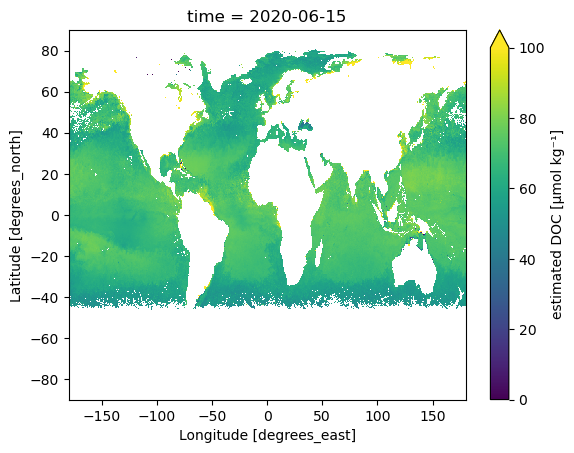

In [7]:
DOC['DOC'].plot(vmin=0, vmax=100)
plt.show()

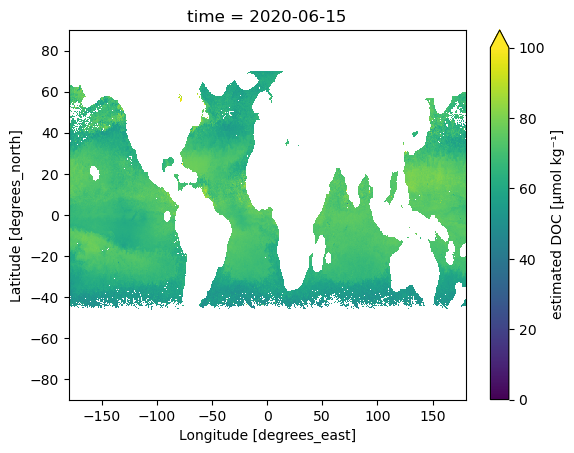

In [8]:
DOC2 = DOC['DOC'].copy()
DOC2 = DOC2.where(ds['dts'] >= config.shorelimit)
DOC2 = DOC2.where(np.abs(ds['lat']) <= config.latlimit)
DOC2.plot(vmax=100, vmin=0)

plt.show()